<h3>Importing necessary libraries</h3>

In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import datasets, layers, models, callbacks
import matplotlib.pyplot as plt

import tensorflow as tf

<h4>Reading dataset</h4>

In [4]:
train_dir = "train"
test_dir = "test"
train_df = pd.read_csv('train.csv')
train_df.tail()

image_names  emergency_or_not
1641    1638.jpg                 0
1642    1095.jpg                 0
1643    1130.jpg                 0
1644    1294.jpg                 0
1645     860.jpg                 1

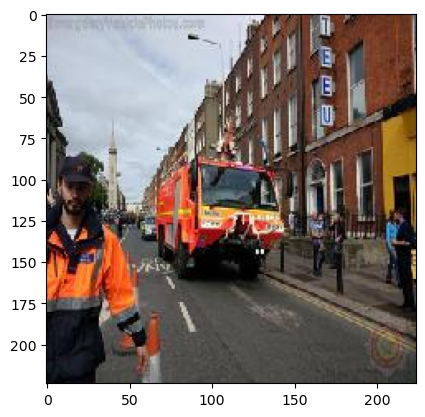

In [12]:
import cv2
import matplotlib.pyplot as plt

# Load the image in BGR format
im2 = cv2.imread("train/10.jpg")

# Convert BGR image to RGB
im2_rgb = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

# Display the RGB image using plt.imshow()
plt.imshow(im2_rgb)
plt.show()

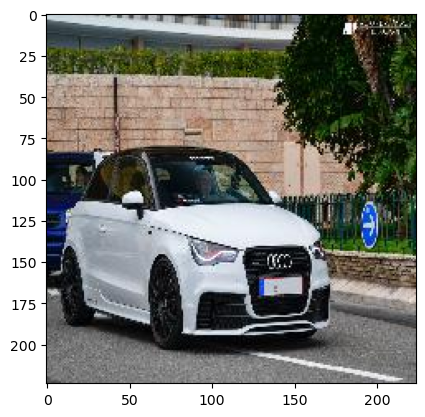

In [13]:
import cv2
import matplotlib.pyplot as plt

# Load the image in BGR format
im2 = cv2.imread("train/2328.jpg")

# Convert BGR image to RGB
im2_rgb = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

# Display the RGB image using plt.imshow()
plt.imshow(im2_rgb)
plt.show()

Converting all datatypes to string

In [14]:
train_df.emergency_or_not=train_df.emergency_or_not.astype(str)

image preprocessing [data augmentation/rescale pixel values/apply horizontal flips/ define a batch size for training]

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255, horizontal_flip = True)
batch_size = 32

data generators provide preprocessed image batches and binary labels for training and validation

In [16]:
traingen = datagen.flow_from_dataframe(dataframe = train_df[:1150],directory = train_dir,x_col ='image_names',
                                            y_col = 'emergency_or_not',class_mode = 'binary',batch_size = batch_size,
                                            target_size = (32,32))


valgen = datagen.flow_from_dataframe(dataframe = train_df[1151:],directory = train_dir,x_col = 'image_names',
                                                y_col ='emergency_or_not',class_mode ='binary',batch_size = 50,
                                                target_size = (32,32))

Found 1150 validated image filenames belonging to 2 classes.
Found 495 validated image filenames belonging to 2 classes.


extract and print the dimensions of the next batch of training and validation samples from the data generators

In [17]:
trainsample = next(traingen)
print("Dimensions of training sample",trainsample[0].shape)
valsample = next(valgen)
print("Dimensions of validation sample",valsample[0].shape)

Dimensions of training sample (32, 32, 32, 3)
Dimensions of validation sample (50, 32, 32, 3)


calculate the total number of training samples and validation samples in the respective data generators

In [19]:
num_train_samples = traingen.samples
num_val_samples = valgen.samples

print("Number of training samples", num_train_samples)
print("Number of validation samples", num_val_samples)

Number of training samples 1150
Number of validation samples 495


<h2>CNN models</h2>

First Model using Data Augmentation

In [20]:
model = Sequential()
model.add(tf.keras.layers.Conv2D(16, (3,3), activation="relu", input_shape=(32,32,3), padding="same"))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(16, (3,3), activation="relu", padding="same"))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Dense(units = 1, activation='sigmoid'))

op = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss = tf.keras.losses.BinaryCrossentropy(from_logits = False)
model.compile(optimizer = op, loss = loss, metrics = ['accuracy'])

history = model.fit(traingen, steps_per_epoch = num_train_samples/50, 
                    epochs = 50, validation_data = valgen,
                    validation_steps = num_val_samples/50)

Epoch 1/50
23/23 [==============================] - 10s 380ms/step - loss: 0.6828 - accuracy: 0.5654 - val_loss: 0.6077 - val_accuracy: 0.6788
Epoch 2/50
23/23 [==============================] - 3s 129ms/step - loss: 0.5797 - accuracy: 0.7079 - val_loss: 0.5300 - val_accuracy: 0.7515
Epoch 3/50
23/23 [==============================] - 2s 92ms/step - loss: 0.5059 - accuracy: 0.7629 - val_loss: 0.5022 - val_accuracy: 0.7636
Epoch 4/50
23/23 [==============================] - 2s 84ms/step - loss: 0.4865 - accuracy: 0.7670 - val_loss: 0.4757 - val_accuracy: 0.7899
Epoch 5/50
23/23 [==============================] - 2s 80ms/step - loss: 0.4621 - accuracy: 0.7738 - val_loss: 0.4737 - val_accuracy: 0.7758
Epoch 6/50
23/23 [==============================] - 2s 78ms/step - loss: 0.4668 - accuracy: 0.7916 - val_loss: 0.4831 - val_accuracy: 0.7879
Epoch 7/50
23/23 [==============================] - 2s 78ms/step - loss: 0.4382 - accuracy: 0.7976 - val_loss: 0.4725 - val_accuracy: 0.7838
Epoch 8/50

In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

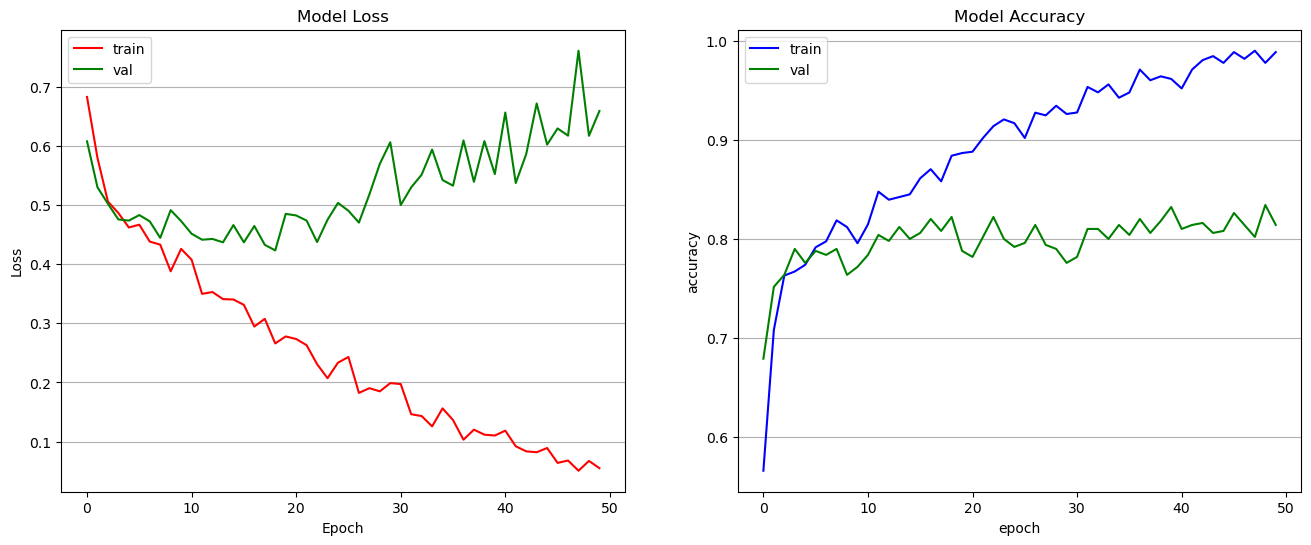

In [25]:
figure = plt.figure(figsize = (16,6))
ax = plt.subplot(121)

ax.plot(history.history['loss'], 'r', label = 'train')
ax.plot(history.history['val_loss'],'g',label = 'val')

plt.legend()
plt.grid(axis = 'y')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")

ax2 = plt.subplot(122)
ax2.plot(history.history['accuracy'], 'b', label="train")
ax2.plot(history.history['val_accuracy'], 'g', label="val")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid(axis='y')
plt.title("Model Accuracy")
plt.savefig("Emergency dataset with data augmentation")

Second Model with Early Stopping

In [26]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('model_es.h5', monitor = 'val_loss',verbose=0, save_best_only=True)

In [27]:
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Conv2D(16, (3, 3), activation="relu", input_shape=(32, 32, 3), padding="same"))
model2.add(tf.keras.layers.MaxPooling2D(2, 2))
model2.add(tf.keras.layers.Conv2D(16, (3, 3), activation="relu", padding="same"))
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(10))
model2.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

callbacks = [early_stopping_callback, model_checkpoint_callback]

# Use the legacy version of Adam optimizer
optimizer_legacy = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)  # Use your desired learning rate
model2.compile(optimizer=optimizer_legacy, loss=loss, metrics=['accuracy'])

history2 = model2.fit(traingen, steps_per_epoch=num_train_samples/50,
                      epochs=50, validation_data=valgen,
                      validation_steps=num_val_samples/50, callbacks=callbacks)

model2.summary()


Epoch 1/50
23/23 [==============================] - 3s 92ms/step - loss: 0.6471 - accuracy: 0.6335 - val_loss: 0.6089 - val_accuracy: 0.6667
Epoch 2/50
 2/23 [=>............................] - ETA: 1s - loss: 0.5695 - accuracy: 0.7500

c:\Users\anasz\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - 2s 78ms/step - loss: 0.5777 - accuracy: 0.7275 - val_loss: 0.5331 - val_accuracy: 0.7434
Epoch 3/50
23/23 [==============================] - 2s 74ms/step - loss: 0.5067 - accuracy: 0.7643 - val_loss: 0.5034 - val_accuracy: 0.7697
Epoch 4/50
23/23 [==============================] - 2s 73ms/step - loss: 0.5129 - accuracy: 0.7589 - val_loss: 0.5457 - val_accuracy: 0.7293
Epoch 5/50
23/23 [==============================] - 2s 75ms/step - loss: 0.4720 - accuracy: 0.7799 - val_loss: 0.4833 - val_accuracy: 0.7616
Epoch 6/50
23/23 [==============================] - 2s 77ms/step - loss: 0.4608 - accuracy: 0.7812 - val_loss: 0.4761 - val_accuracy: 0.7859
Epoch 7/50
23/23 [==============================] - 2s 76ms/step - loss: 0.4211 - accuracy: 0.7888 - val_loss: 0.5446 - val_accuracy: 0.7374
Epoch 8/50
23/23 [==============================] - 2s 74ms/step - loss: 0.3975 - accuracy: 0.8179 - val_loss: 0.4997 - val_accuracy: 0.7636
Epoch 9/50
23/23 [======

In [28]:
history2.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

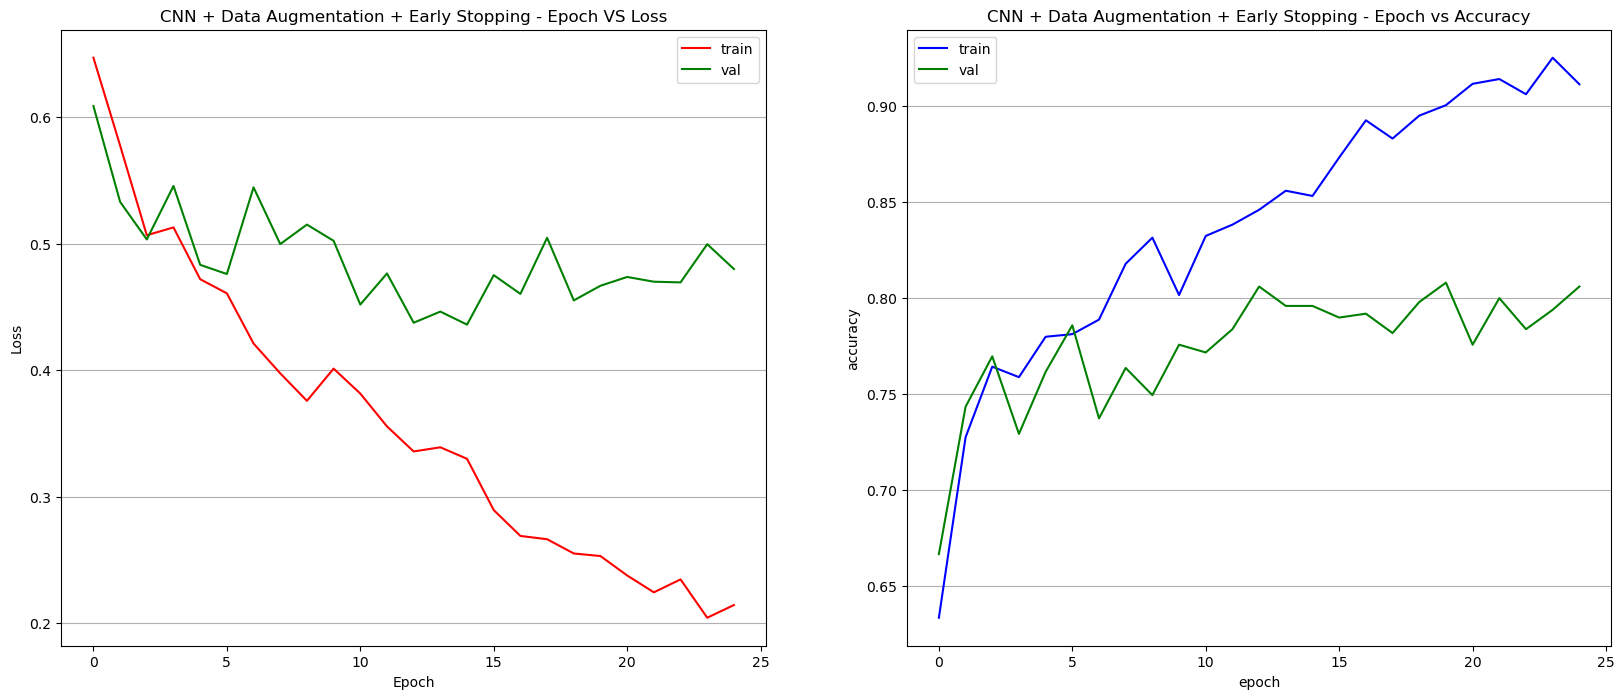

In [33]:
figure = plt.figure(figsize = (20,8))

ax1 = plt.subplot(121)
ax1.plot(history2.history['loss'], 'r', label = 'train')
ax1.plot(history2.history['val_loss'],'g',label = 'val')
plt.legend()
plt.grid(axis = 'y')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN + Data Augmentation + Early Stopping - Epoch VS Loss")
ax2 = plt.subplot(122)
ax2.plot(history2.history['accuracy'], 'b', label="train")
ax2.plot(history2.history['val_accuracy'], 'g', label="val")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid(axis='y')

plt.title("CNN + Data Augmentation + Early Stopping - Epoch vs Accuracy")


Third model with dropout 0.2

In [34]:

model3 = tf.keras.models.Sequential()

model3.add(tf.keras.layers.Conv2D(16, (3, 3), activation="relu", input_shape=(32, 32, 3), padding="same"))
model3.add(tf.keras.layers.MaxPooling2D(2, 2))
model3.add(tf.keras.layers.Conv2D(16, (3, 3), activation="relu", padding="same"))
model3.add(tf.keras.layers.Flatten())
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.Dense(10))
model3.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Use the legacy version of Adam optimizer
optimizer_legacy = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)  # Use your desired learning rate
model3.compile(optimizer=optimizer_legacy, loss=loss, metrics=['accuracy'])


history3 = model3.fit(traingen, steps_per_epoch=num_train_samples/50,
                      epochs=50, validation_data=valgen,
                      validation_steps=num_val_samples/50)


Epoch 1/50
23/23 [==============================] - 3s 120ms/step - loss: 0.6225 - accuracy: 0.6526 - val_loss: 0.5599 - val_accuracy: 0.7313
Epoch 2/50
23/23 [==============================] - 2s 85ms/step - loss: 0.5173 - accuracy: 0.7629 - val_loss: 0.5075 - val_accuracy: 0.7616
Epoch 3/50
23/23 [==============================] - 2s 81ms/step - loss: 0.5257 - accuracy: 0.7602 - val_loss: 0.5494 - val_accuracy: 0.7232
Epoch 4/50
23/23 [==============================] - 2s 89ms/step - loss: 0.5017 - accuracy: 0.7541 - val_loss: 0.4856 - val_accuracy: 0.7838
Epoch 5/50
23/23 [==============================] - 2s 96ms/step - loss: 0.4814 - accuracy: 0.7916 - val_loss: 0.4748 - val_accuracy: 0.7758
Epoch 6/50
23/23 [==============================] - 2s 79ms/step - loss: 0.4535 - accuracy: 0.7888 - val_loss: 0.5123 - val_accuracy: 0.7556
Epoch 7/50
23/23 [==============================] - 2s 69ms/step - loss: 0.4255 - accuracy: 0.8207 - val_loss: 0.4900 - val_accuracy: 0.7758
Epoch 8/50
2

Text(0.5, 1.0, 'CNN + Data Augmentation + Dropout = 0.2 - Epoch vs Accuracy')

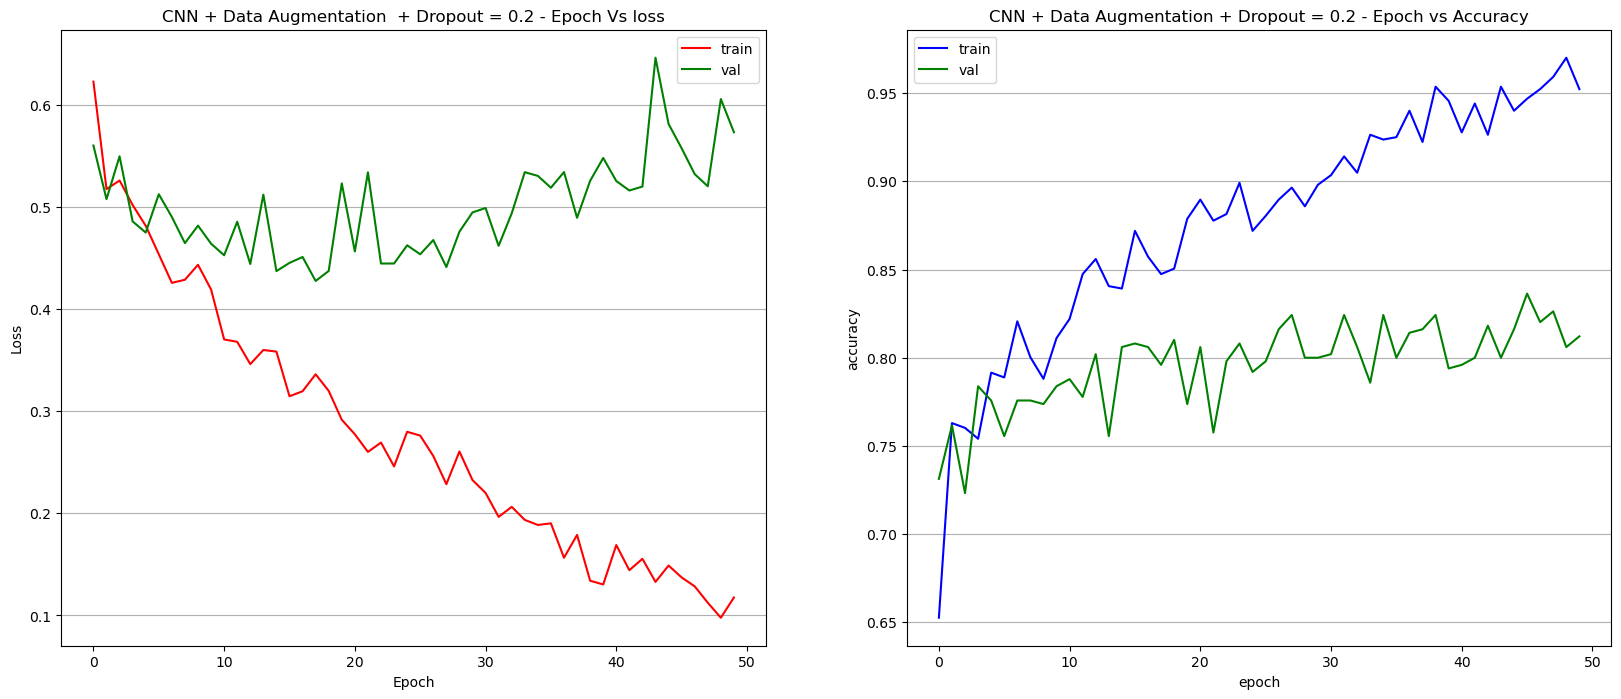

In [37]:
figure = plt.figure(figsize = (20,8))
ax = plt.subplot(121)

ax.plot(history3.history['loss'], 'r', label = 'train')
ax.plot(history3.history['val_loss'],'g',label = 'val')

plt.legend()
plt.grid(axis = 'y')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN + Data Augmentation  + Dropout = 0.2 - Epoch Vs loss")

ax2 = plt.subplot(122)
ax2.plot(history3.history['accuracy'], 'b', label="train")
ax2.plot(history3.history['val_accuracy'], 'g', label="val")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid(axis='y')

plt.title("CNN + Data Augmentation + Dropout = 0.2 - Epoch vs Accuracy")



Fourth Model with L1 regularization

In [38]:
model5 = tf.keras.models.Sequential()

model5.add(tf.keras.layers.Conv2D(16, (3, 3), activation="relu", input_shape=(32, 32, 3), kernel_regularizer=tf.keras.regularizers.l1(0.01)))
model5.add(tf.keras.layers.MaxPooling2D(2, 2))
model5.add(tf.keras.layers.Conv2D(16, (3, 3), activation="relu", padding="same"))
model5.add(tf.keras.layers.Flatten())
model5.add(tf.keras.layers.Dense(10))
model5.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Use the legacy version of Adam optimizer
optimizer_legacy = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)  # Use your desired learning rate
model5.compile(optimizer=optimizer_legacy, loss=loss, metrics=['accuracy'])



history5 = model5.fit(traingen, steps_per_epoch=num_train_samples/50,
                      epochs=50, validation_data=valgen,
                      validation_steps=num_val_samples/50)


Epoch 1/50
23/23 [==============================] - 3s 96ms/step - loss: 1.0168 - accuracy: 0.6209 - val_loss: 0.9420 - val_accuracy: 0.6747
Epoch 2/50
23/23 [==============================] - 2s 78ms/step - loss: 0.8901 - accuracy: 0.7065 - val_loss: 0.9085 - val_accuracy: 0.6646
Epoch 3/50
23/23 [==============================] - 2s 79ms/step - loss: 0.8520 - accuracy: 0.7296 - val_loss: 0.8116 - val_accuracy: 0.7495
Epoch 4/50
23/23 [==============================] - 2s 99ms/step - loss: 0.8033 - accuracy: 0.7520 - val_loss: 0.8247 - val_accuracy: 0.7172
Epoch 5/50
23/23 [==============================] - 2s 92ms/step - loss: 0.7351 - accuracy: 0.7847 - val_loss: 0.7560 - val_accuracy: 0.7535
Epoch 6/50
23/23 [==============================] - 2s 85ms/step - loss: 0.7174 - accuracy: 0.7916 - val_loss: 0.7234 - val_accuracy: 0.7778
Epoch 7/50
23/23 [==============================] - 2s 88ms/step - loss: 0.6822 - accuracy: 0.7861 - val_loss: 0.7147 - val_accuracy: 0.7717
Epoch 8/50
23

Text(0.5, 1.0, 'CNN + Data Augmentation + L1 regularization - Epoch VS Accuracy')

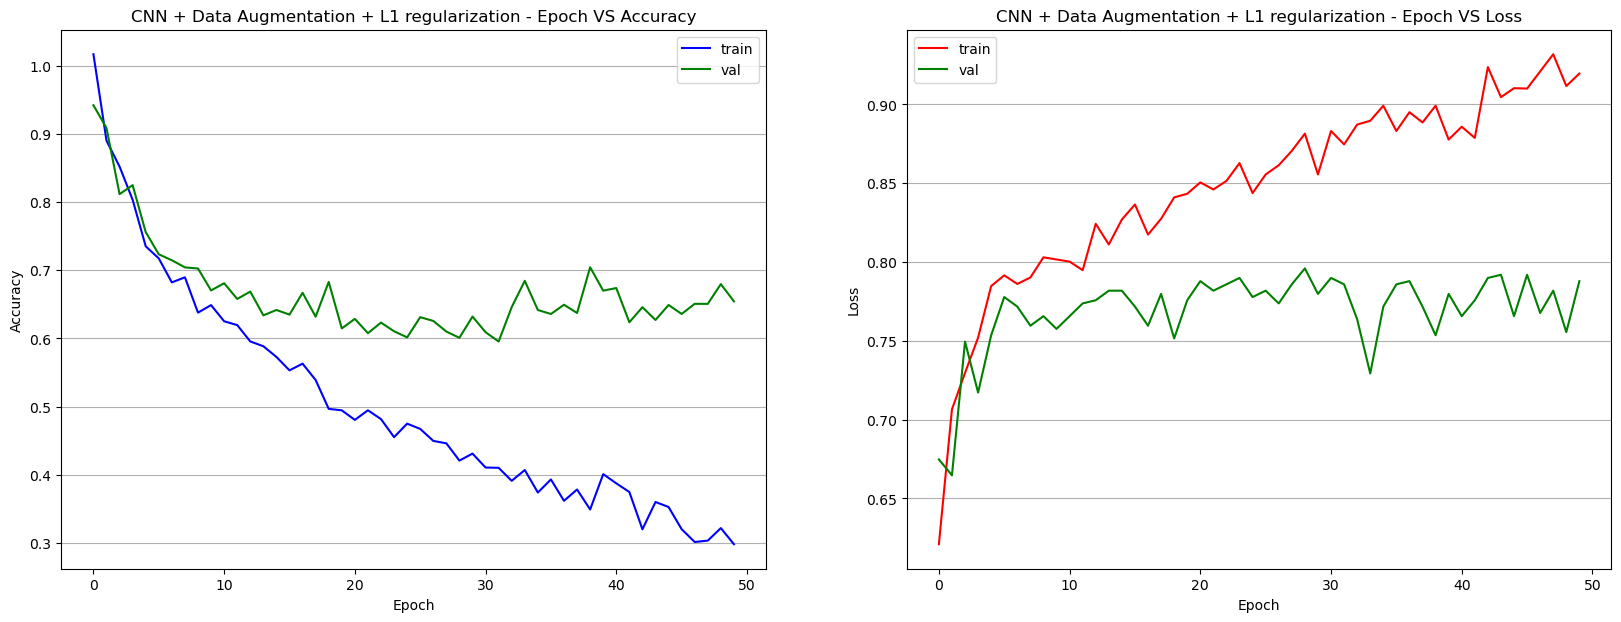

In [44]:
figure = plt.figure(figsize = (20,7))

ax2 = plt.subplot(122)
ax2.plot(history5.history['accuracy'], 'r', label = 'train')
ax2.plot(history5.history['val_accuracy'],'g',label = 'val')
plt.legend()
plt.grid(axis = 'y')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN + Data Augmentation + L1 regularization - Epoch VS Loss")

ax = plt.subplot(121)
ax.plot(history5.history['loss'], 'b', label = 'train')
ax.plot(history5.history['val_loss'],'g',label = 'val')
plt.legend()
plt.grid(axis = 'y')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN + Data Augmentation + L1 regularization - Epoch VS Accuracy")

Fifth model with Ridge Regression Regularization

In [45]:
model6 = tf.keras.models.Sequential()

model6.add(tf.keras.layers.Conv2D(16, (3, 3), activation="relu", input_shape=(32, 32, 3), kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model6.add(tf.keras.layers.MaxPooling2D(2, 2))
model6.add(tf.keras.layers.Conv2D(16, (3, 3), activation="relu", padding="same"))
model6.add(tf.keras.layers.Flatten())
model6.add(tf.keras.layers.Dense(10))
model6.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Use the legacy version of Adam optimizer
optimizer_legacy = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)  # Use your desired learning rate
model6.compile(optimizer=optimizer_legacy, loss=loss, metrics=['accuracy'])


history6 = model6.fit(traingen, steps_per_epoch=num_train_samples/50,
                      epochs=50, validation_data=valgen,
                      validation_steps=num_val_samples/50)


Epoch 1/50
23/23 [==============================] - 4s 120ms/step - loss: 0.7157 - accuracy: 0.6117 - val_loss: 0.6439 - val_accuracy: 0.6970
Epoch 2/50
23/23 [==============================] - 2s 89ms/step - loss: 0.6056 - accuracy: 0.7330 - val_loss: 0.5592 - val_accuracy: 0.7374
Epoch 3/50
23/23 [==============================] - 2s 88ms/step - loss: 0.5803 - accuracy: 0.7357 - val_loss: 0.5811 - val_accuracy: 0.7131
Epoch 4/50
23/23 [==============================] - 2s 94ms/step - loss: 0.5394 - accuracy: 0.7589 - val_loss: 0.5487 - val_accuracy: 0.7475
Epoch 5/50
23/23 [==============================] - 2s 84ms/step - loss: 0.5129 - accuracy: 0.7758 - val_loss: 0.5253 - val_accuracy: 0.7737
Epoch 6/50
23/23 [==============================] - 2s 94ms/step - loss: 0.5047 - accuracy: 0.7799 - val_loss: 0.5110 - val_accuracy: 0.7677
Epoch 7/50
23/23 [==============================] - 2s 81ms/step - loss: 0.4947 - accuracy: 0.7956 - val_loss: 0.5024 - val_accuracy: 0.7758
Epoch 8/50
2

Text(0.5, 1.0, 'CNN + Data Augmentation + L2 regularization - Epoch VS Accuracy')

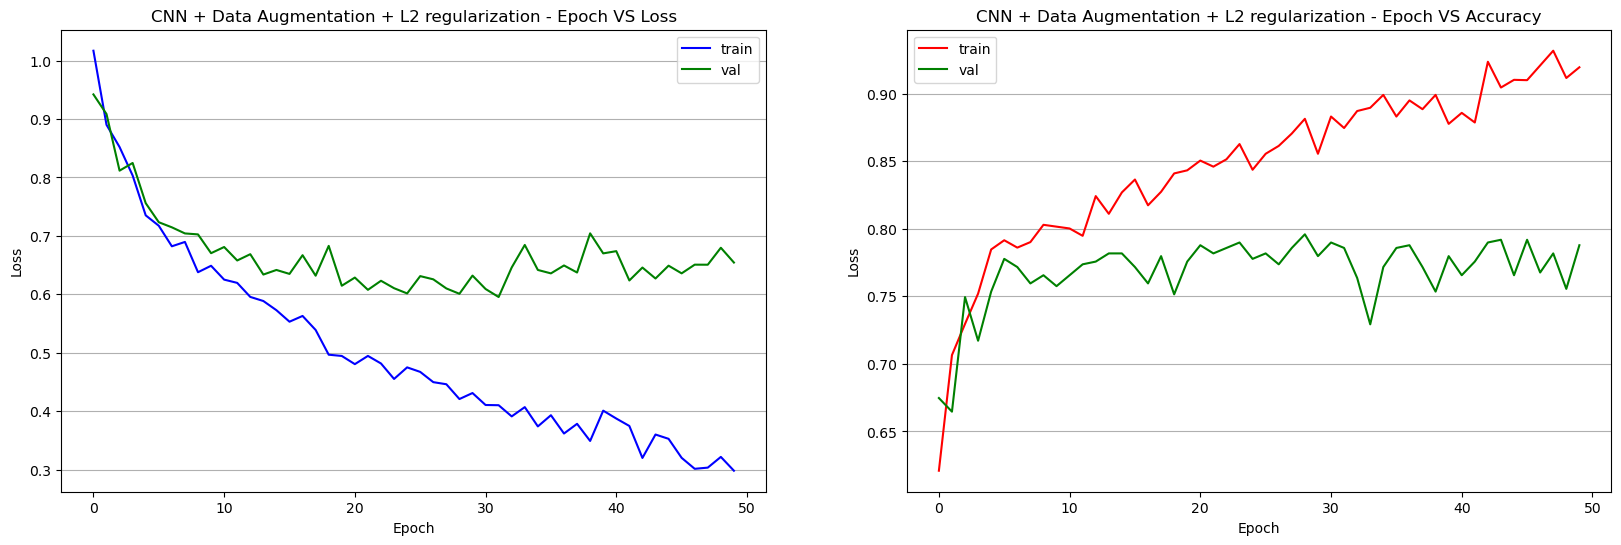

In [46]:
figure = plt.figure(figsize = (20,6))

ax = plt.subplot(121)
ax.plot(history5.history['loss'], 'b', label = 'train')
ax.plot(history5.history['val_loss'],'g',label = 'val')
plt.legend()
plt.grid(axis = 'y')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN + Data Augmentation + L2 regularization - Epoch VS Loss")

ax2 = plt.subplot(122)
ax2.plot(history5.history['accuracy'], 'r', label = 'train')
ax2.plot(history5.history['val_accuracy'],'g',label = 'val')
plt.legend()
plt.grid(axis = 'y')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN + Data Augmentation + L2 regularization - Epoch VS Accuracy")

In [47]:
import pandas as pd
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the test dataset
test_df = pd.read_csv('test.csv')
test_dir = "test"

# Create the test data generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_dataframe(dataframe=test_df, directory=test_dir, x_col='image_names',
                                            y_col=None, class_mode=None, batch_size=32, target_size=(32, 32),
                                            shuffle=False)

# Load the trained model
# Replace 'model_es.h5' with the name of the saved best model file from the training step
best_model = load_model('model_es.h5')

# Evaluate the model on the test data
predictions = best_model.predict(test_gen)

# Convert predictions to binary labels (0 or 1) based on a threshold (e.g., 0.5)
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)

# Create a submission dataframe with image names and corresponding predicted labels
submission_df = pd.DataFrame({'image_names': test_df['image_names'], 'emergency_or_not': predicted_labels.flatten()})

# Save the submission dataframe to a CSV file
submission_df.to_csv('submission.csv', index=False)


Found 706 validated image filenames.
23/23 [==============================] - 5s 198ms/step


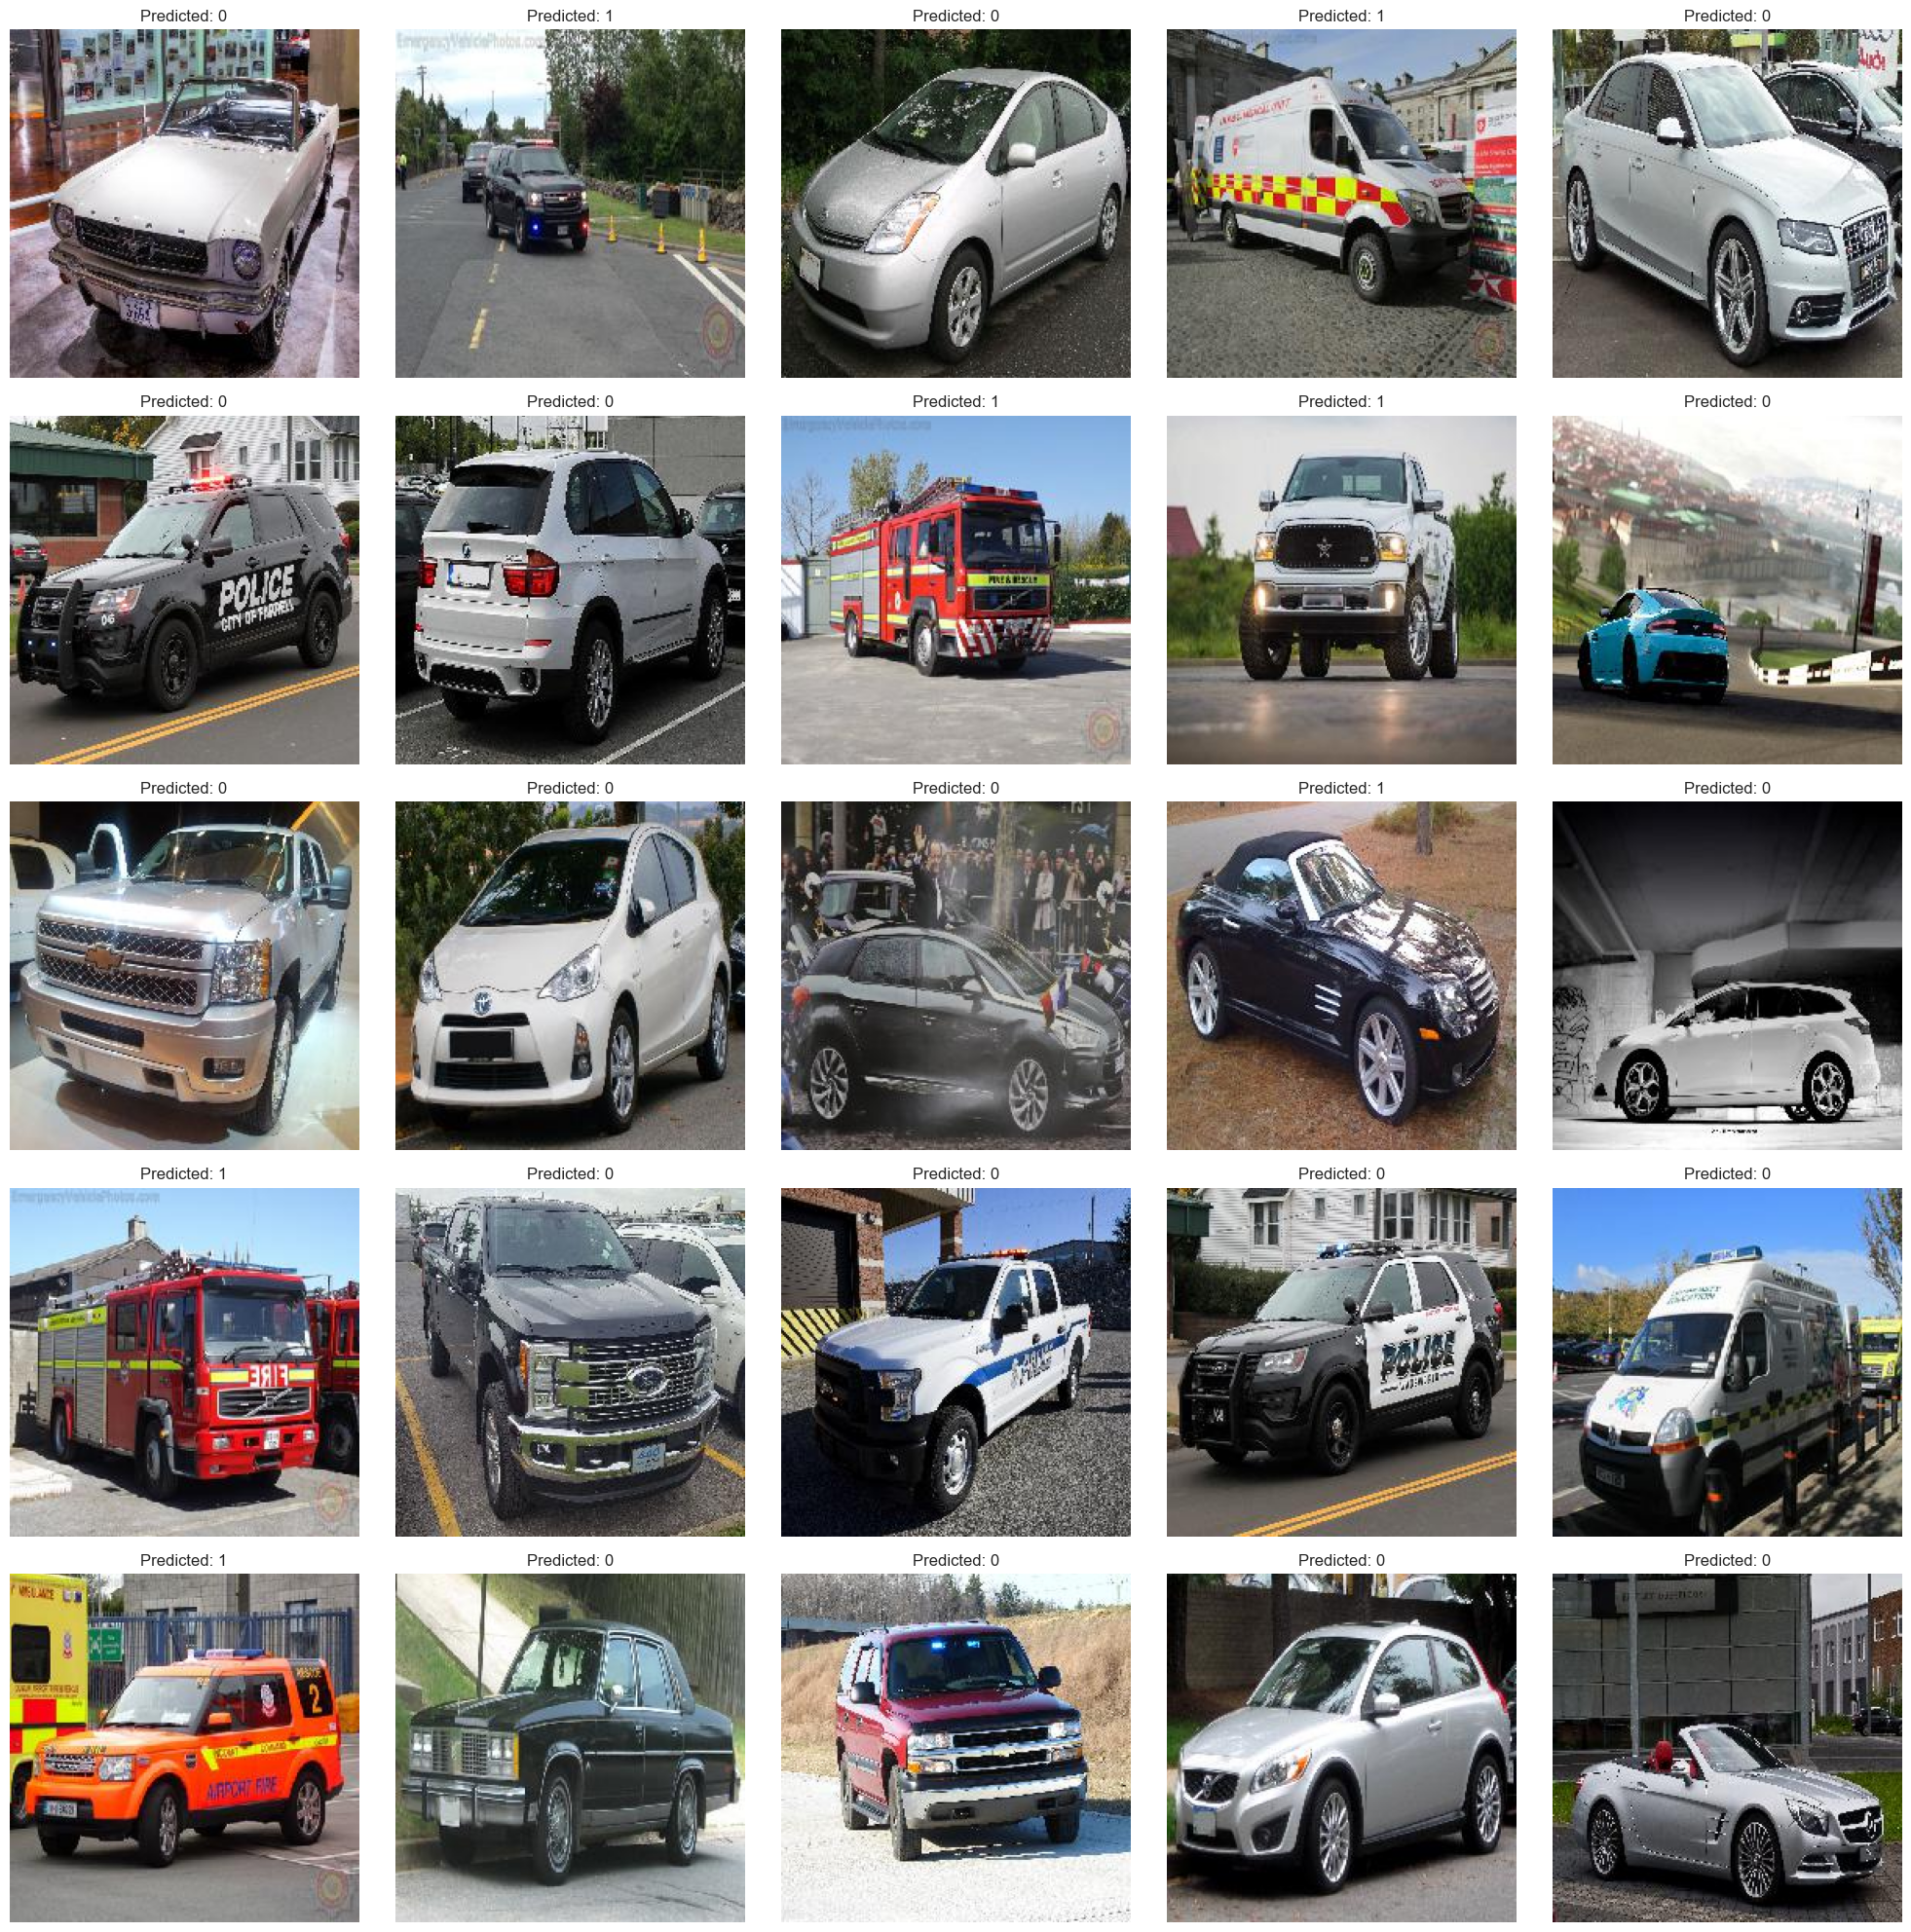

In [67]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the submission dataframe
submission_df = pd.read_csv('submission.csv')

# Load the test dataset
test_dir = "test"

# Function to plot images along with their predicted labels
def plot_images_with_labels(images, predicted_labels, nrows=5, ncols=5):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(f'Predicted: {predicted_labels[i]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Prepare the test data for visualization
test_images = []
for image_name in submission_df['image_names']:
    img_path = f"{test_dir}/{image_name}"
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    test_images.append(img)

# Convert predicted labels to integers (0 or 1)
predicted_labels = submission_df['emergency_or_not'].values.astype(int)

# Plot the images along with their predicted labels
plot_images_with_labels(test_images, predicted_labels)


Epoch 1/50
23/23 [==============================] - 2s 95ms/step - loss: 0.0647 - accuracy: 0.9823 - val_loss: 0.6832 - val_accuracy: 0.8121
Epoch 2/50
23/23 [==============================] - 2s 101ms/step - loss: 0.0723 - accuracy: 0.9768 - val_loss: 0.8850 - val_accuracy: 0.8000
Epoch 3/50
23/23 [==============================] - 2s 91ms/step - loss: 0.0663 - accuracy: 0.9837 - val_loss: 0.6927 - val_accuracy: 0.8061
Epoch 4/50
23/23 [==============================] - 2s 78ms/step - loss: 0.0434 - accuracy: 0.9877 - val_loss: 0.6761 - val_accuracy: 0.8081
Epoch 5/50
23/23 [==============================] - 2s 79ms/step - loss: 0.0526 - accuracy: 0.9837 - val_loss: 0.7250 - val_accuracy: 0.8101
Epoch 6/50
23/23 [==============================] - 3s 136ms/step - loss: 0.0521 - accuracy: 0.9823 - val_loss: 0.6985 - val_accuracy: 0.8101
Epoch 7/50
23/23 [==============================] - 3s 132ms/step - loss: 0.0441 - accuracy: 0.9905 - val_loss: 0.7315 - val_accuracy: 0.7919
Epoch 8/50

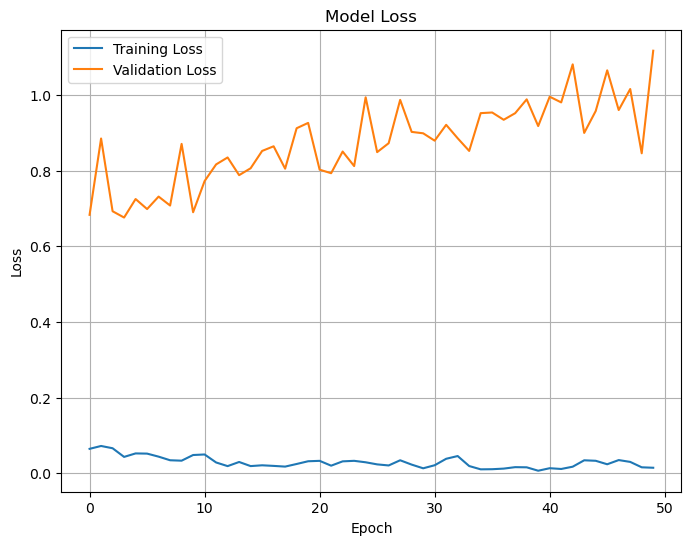

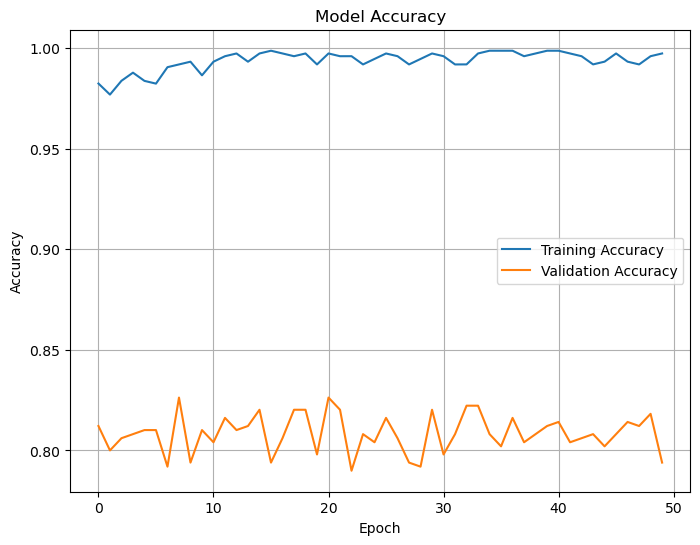

In [49]:
import matplotlib.pyplot as plt

history = model.fit(traingen, steps_per_epoch=num_train_samples/50,
                    epochs=50, validation_data=valgen,
                    validation_steps=num_val_samples/50)


# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Found 1000 validated image filenames belonging to 2 classes.
Found 646 validated image filenames belonging to 2 classes.
Epoch 1/50
32/32 [==============================] - 6s 171ms/step - loss: 0.6924 - accuracy: 0.5580 - val_loss: 0.6795 - val_accuracy: 0.6176 - lr: 0.0010
Epoch 2/50
 1/32 [..............................] - ETA: 3s - loss: 0.6927 - accuracy: 0.5000

c:\Users\anasz\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - 3s 107ms/step - loss: 0.6778 - accuracy: 0.5820 - val_loss: 0.6499 - val_accuracy: 0.6486 - lr: 0.0010
Epoch 3/50
32/32 [==============================] - 4s 121ms/step - loss: 0.6654 - accuracy: 0.6330 - val_loss: 0.6600 - val_accuracy: 0.6517 - lr: 0.0010
Epoch 4/50
32/32 [==============================] - 3s 108ms/step - loss: 0.6486 - accuracy: 0.6570 - val_loss: 0.6058 - val_accuracy: 0.6889 - lr: 0.0010
Epoch 5/50
32/32 [==============================] - 3s 106ms/step - loss: 0.6362 - accuracy: 0.6490 - val_loss: 0.6021 - val_accuracy: 0.7028 - lr: 0.0010
Epoch 6/50
32/32 [==============================] - 3s 105ms/step - loss: 0.6225 - accuracy: 0.6750 - val_loss: 0.5778 - val_accuracy: 0.7043 - lr: 0.0010
Epoch 7/50
32/32 [==============================] - 4s 111ms/step - loss: 0.6224 - accuracy: 0.6650 - val_loss: 0.5779 - val_accuracy: 0.7105 - lr: 0.0010
Epoch 8/50
32/32 [==============================] - 5s 153ms/step - loss: 0.6154 

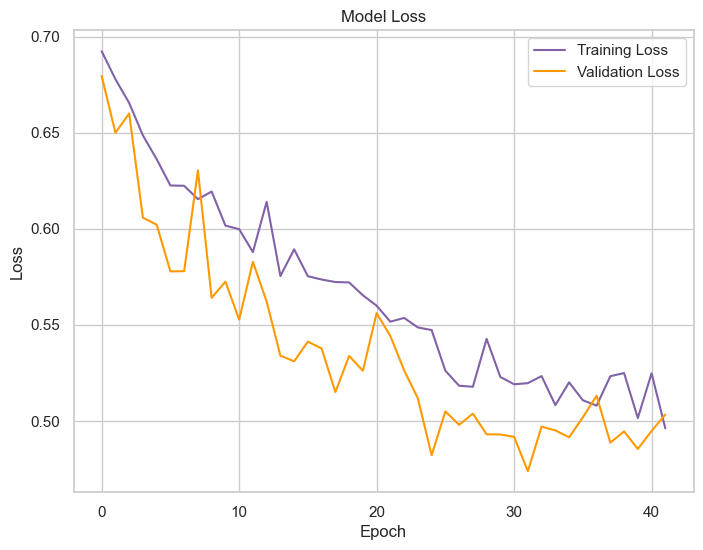

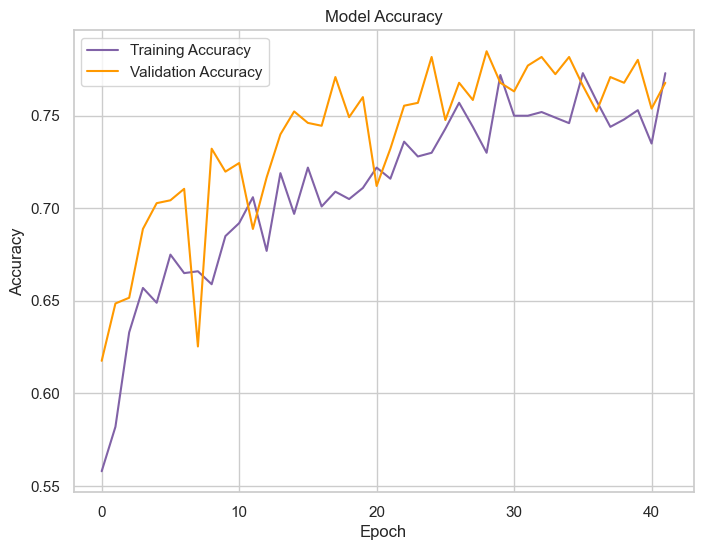

Found 706 validated image filenames.
23/23 [==============================] - 1s 40ms/step


In [61]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Load the dataset
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_dir = "train"
test_dir = "test"

# Convert 'emergency_or_not' column to strings
train_df['emergency_or_not'] = train_df['emergency_or_not'].astype(str)

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Split the dataset into training and validation sets
train_gen = train_datagen.flow_from_dataframe(dataframe=train_df[:1000], directory=train_dir, x_col='image_names',
                                              y_col='emergency_or_not', class_mode='binary', batch_size=32,
                                              target_size=(32, 32))

val_gen = train_datagen.flow_from_dataframe(dataframe=train_df[1000:], directory=train_dir, x_col='image_names',
                                            y_col='emergency_or_not', class_mode='binary', batch_size=32,
                                            target_size=(32, 32))

# Model Architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, verbose=1, min_lr=0.00001)

# Train the model
history = model.fit(train_gen, steps_per_epoch=len(train_gen), epochs=50, validation_data=val_gen,
                    validation_steps=len(val_gen), callbacks=[early_stopping, model_checkpoint, reduce_lr])

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', color = '#8162a7')
plt.plot(history.history['val_loss'], label='Validation Loss', color = '#ff9900')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color = '#8162a7')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color = '#ff9900')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Load the best model and make predictions on the test dataset
best_model = load_model('best_model.h5')
test_gen = test_datagen.flow_from_dataframe(dataframe=test_df, directory=test_dir, x_col='image_names',
                                            y_col=None, class_mode=None, batch_size=32, target_size=(32, 32),
                                            shuffle=False)

predictions = best_model.predict(test_gen)
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)

# Create a submission dataframe and save to a CSV file
submission_df = pd.DataFrame({'image_names': test_df['image_names'], 'emergency_or_not': predicted_labels.flatten()})
submission_df.to_csv('submission.csv', index=False)


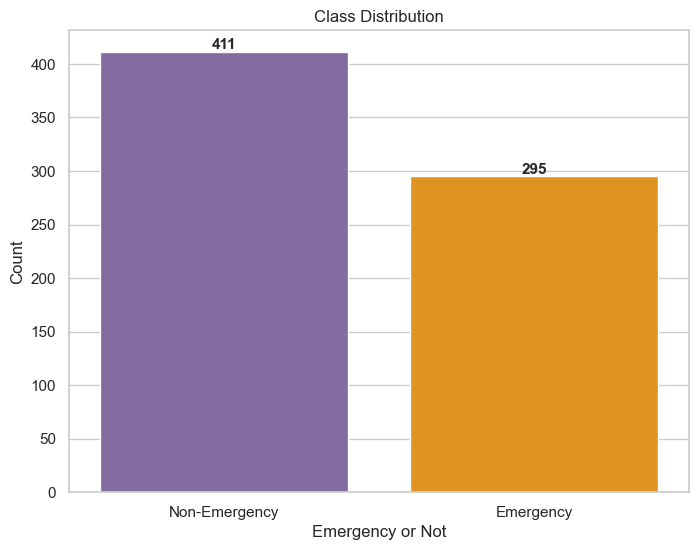

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for the plot (optional but makes the plot look nicer)
sns.set(style="whitegrid")

# Count the occurrences of each class in the 'emergency_or_not' column
class_counts = submission_df['emergency_or_not'].value_counts()
colors = ['#8162a7', '#ff9900'] 
# Create the bar plot using Seaborn
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette=colors)
plt.xlabel('Emergency or Not')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(ticks=[0, 1], labels=['Non-Emergency', 'Emergency'], rotation=0)

# Add total values on top of each bar
for index, value in enumerate(class_counts.values):
    ax.text(index, value, str(value), ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.show()


<h1>Genetic Algorithm</h1>

In [52]:
# Load the emergency vehicle dataset
emergency_df = pd.read_csv('submission.csv')

# Count the occurrences of emergency vehicles (where 'emergency_or_not' is 1)
emergency_vehicle_frequency = emergency_df['emergency_or_not'].sum()

# Calculate the total number of vehicles in the dataset
total_vehicles = len(emergency_df)

# Calculate the frequency of emergency vehicles
frequency = emergency_vehicle_frequency / total_vehicles

print("Frequency of emergency vehicles: {:.2%}".format(frequency))

Frequency of emergency vehicles: 46.03%


In [53]:
# Import necessary libraries
import numpy as np

# Define the chromosome length (number of genes representing the traffic light timings)
num_intersections = 2
num_lights_per_intersection = 4
chromosome_length = num_intersections * num_lights_per_intersection * 3  # 2 intersections * 4 lights * 3 timings (green, yellow, red)

# Define the range for each gene (traffic light timing duration in seconds)
min_green_time = 10  # Minimum green time (seconds)
max_green_time = 60  # Maximum green time (seconds)

min_yellow_time = 2   # Minimum yellow time (seconds)
max_yellow_time = 5   # Maximum yellow time (seconds)

min_red_time = 10     # Minimum red time (seconds)
max_red_time = 30     # Maximum red time (seconds)

# Define the function to create a random chromosome
def create_random_chromosome():
    chromosome = []
    for _ in range(num_intersections):
        for _ in range(num_lights_per_intersection):
            green_time = np.random.randint(min_green_time, max_green_time + 1)
            yellow_time = np.random.randint(min_yellow_time, max_yellow_time + 1)
            red_time = np.random.randint(min_red_time, max_red_time + 1)
            chromosome.extend([green_time, yellow_time, red_time])
    return chromosome

# Example of creating a random chromosome
random_chromosome = create_random_chromosome()
print("Random Chromosome:", random_chromosome)


Random Chromosome: [17, 4, 16, 53, 4, 11, 20, 3, 27, 35, 2, 22, 16, 4, 21, 35, 4, 21, 30, 3, 24, 54, 3, 17]


In [55]:
import pandas as pd

# Load the traffic data
traffic_data = pd.read_csv('Source_data.csv')

# Drop unnecessary columns (if any) that are not needed for the fitness function
# For example, 'Date', 'Day_str', 'Fastest_Route_Distance', 'Fastest_Route_Name', etc.
traffic_data = traffic_data.drop(columns=['Date', 'Day_str', 'Fastest_Route_Distance', 'Fastest_Route_Name'])

# Display the first few rows to check the data
print(traffic_data.head())


  Destination_Location  Fastest_Route_Time Holiday Special_Condition  \
0           9th_avenue                  60      no                no   
1            centaurus                 120      no                no   
2          crown_plaza                  60      no                no   
3         roshan_plaza                 180      no                no   
4      salt_and_pepper                 300      no                no   

  Starting_Location Sys_Time  Weather     Congestion_Pred  
0  capital_gymkhana  0:00:01  Showers              smooth  
1        9th_avenue  0:00:09  Showers    highly congested  
2         centaurus  0:00:17  Showers              smooth  
3       crown_plaza  0:00:24  Showers              smooth  
4      roshan_plaza  0:00:31  Showers  slightly congested  


In [56]:
import pandas as pd
import numpy as np

# Load the emergency vehicle dataset
emergency_df = pd.read_csv('submission.csv')

# Calculate the frequency of emergency vehicles in the dataset
emergency_vehicle_frequency = emergency_df['emergency_or_not'].sum()
total_vehicles = len(emergency_df)
frequency = emergency_vehicle_frequency / total_vehicles

# Load the traffic data
traffic_data = pd.read_csv('Source_data.csv')

# Define the chromosome length (number of genes representing the traffic light timings)
num_intersections = 2
num_lights_per_intersection = 4
chromosome_length = num_intersections * num_lights_per_intersection * 3  # 2 intersections * 4 lights * 3 timings (green, yellow, red)

# Define the range for each gene (traffic light timing duration in seconds)
min_green_time = 10  # Minimum green time (seconds)
max_green_time = 60  # Maximum green time (seconds)

min_yellow_time = 2   # Minimum yellow time (seconds)
max_yellow_time = 5   # Maximum yellow time (seconds)

min_red_time = 10     # Minimum red time (seconds)
max_red_time = 30     # Maximum red time (seconds)

# Define the fitness function
def fitness_function(chromosome):
    fitness_score = 0.0

    # Loop through each intersection
    for intersection_id in range(num_intersections):
        # Extract the traffic light timings for the current intersection from the chromosome
        start_idx = intersection_id * num_lights_per_intersection * 3
        end_idx = start_idx + num_lights_per_intersection * 3
        intersection_timings = chromosome[start_idx:end_idx]

        # Calculate a heuristic-based fitness score for the intersection based on timings
        green_times = intersection_timings[::3]
        yellow_times = intersection_timings[1::3]
        red_times = intersection_timings[2::3]

        # For simplicity, let's assume fitness is higher if green times are longer and waiting times are lower
        avg_waiting_times = np.mean(red_times)
        fitness_score += 1 / (avg_waiting_times + 1)  # Heuristic: Inverse of waiting times (higher is better)
        fitness_score += np.sum(green_times)  # Heuristic: Longer green times are better

    # Incorporate the frequency of emergency vehicles into the fitness function
    fitness_score += 0.5 * (1 / (1 + frequency))

    return fitness_score


In [57]:
import numpy as np

# Define the number of chromosomes (traffic light timings) in the population
population_size = 100

# Generate a random population of chromosomes
population = [np.random.randint(10, 31, size=chromosome_length) for _ in range(population_size)]

# Define the number of generations for the genetic algorithm
num_generations = 100

# Define the probability of crossover and mutation
crossover_prob = 0.8
mutation_prob = 0.2

# Genetic algorithm loop
for generation in range(num_generations):
    # Evaluate the fitness of each chromosome in the population using the fitness function
    fitness_scores = [fitness_function(chromosome) for chromosome in population]

    # Find the index of the chromosome with the highest fitness (minimizing fitness function)
    best_chromosome_index = np.argmax(fitness_scores)

    # Select the best chromosome from the population (Elitism)
    best_chromosome = population[best_chromosome_index]

    # Create an empty new population to store the next generation
    new_population = []

    # Perform selection, crossover, and mutation to create the new population
    while len(new_population) < population_size:
        # Selection: Choose two parents from the population using tournament selection
        parent1_idx = np.random.randint(0, population_size)
        parent2_idx = np.random.randint(0, population_size)
        parent1 = population[parent1_idx]
        parent2 = population[parent2_idx]

        # Crossover: Apply crossover with a certain probability
        if np.random.rand() < crossover_prob:
            crossover_point = np.random.randint(1, chromosome_length - 1)
            child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
        else:
            child1 = parent1
            child2 = parent2

        # Mutation: Apply mutation to each child with a certain probability
        if np.random.rand() < mutation_prob:
            mutation_point = np.random.randint(0, chromosome_length)
            child1[mutation_point] = np.random.randint(min_green_time, max_green_time + 1)
            mutation_point = np.random.randint(0, chromosome_length)
            child2[mutation_point] = np.random.randint(min_green_time, max_green_time + 1)

        # Add the children to the new population
        new_population.append(child1)
        new_population.append(child2)

    population = new_population



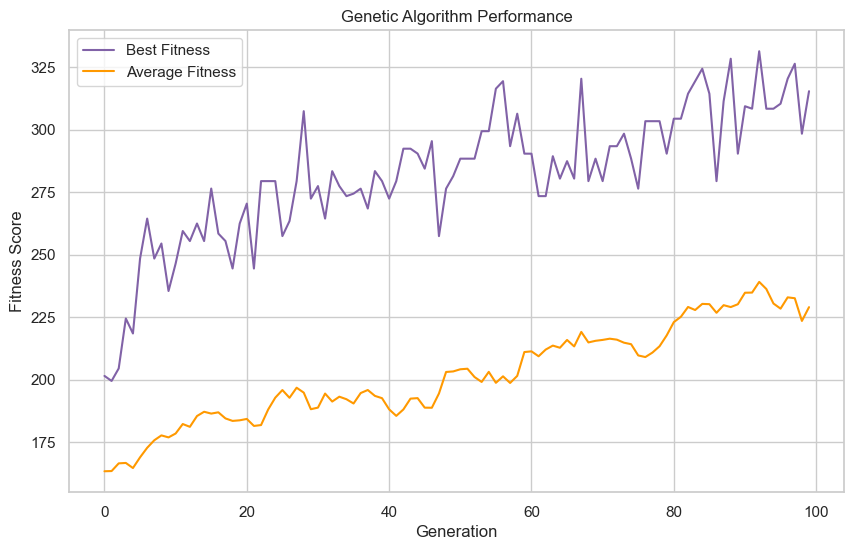

In [68]:

generations = range(num_generations)

plt.figure(figsize=(10, 6))
plt.plot(generations, best_fitness_scores, label='Best Fitness', color='#8162a7')
plt.plot(generations, average_fitness_scores, label='Average Fitness', color='#ff9900')
plt.xlabel('Generation')
plt.ylabel('Fitness Score')
plt.title('Genetic Algorithm Performance')
plt.legend()
plt.grid(True)
plt.show()
